In [3]:
# Imports
MIN_REQ_PYTHON = (3,6)
import ldap3
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import string
from tkinter import Tk
from tkinter.filedialog import askopenfilename

In [4]:
# INPUT A DN LIST
# ATTENTION: no header
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

#f = open(filename, "r")
#print(f.read())
df_dnlist = pd.read_csv(filename,sep=';',header=None)
str_base_dn = ""

C:/Users/michelj/Documents/011_RED/PT_008/pt_008_s-emfaprd_fla_dn.csv


In [15]:
# INPUT THE DC BASE TO TRIM
# OU=Retail North America,DC=LUXGROUP,DC=NET
str_base_dn = input()

In [12]:
print(str_base_dn)

OU=Retail North America,DC=LUXGROUP,DC=NET


In [18]:
# BUILD 'df_host_dn'
d = {'host':[""], 'dn':[""]}

df_host_dn = pd.DataFrame(data=d)
index=0

for str_dn in df_dnlist[1]:
    
    str_dn_short=""

    if str_base_dn != "":
        str_dn_short = str_dn.strip().split(str_base_dn)[0]
        str_dn_short = str_dn_short.strip(",")
    else:
        str_dn_short = str_dn.strip()
    
    df_dn_cast = ldap3.utils.dn.parse_dn(str_dn_short)
    df_host_dn.at[index, 'host'] = df_dn_cast[0][1]
    
    i=0; ou =""
    for xn in df_dn_cast:
        if i > 0:
            ou = ou + xn[0]+"="+xn[1]+xn[2]
        i = i +1
    
    df_host_dn.at[index, 'dn'] = ou
    index = index + 1

display(df_host_dn)


,host,dn
0,USMSSSLXP001,"OU=BUR,OU=Infrastructure,OU=HPNAServers,OU=_HP"
1,USSWVULXP596,"OU=Legal Technologies,OU=Business Application,..."
2,USSWVULXP595,"OU=Altiris,OU=Business Application,OU=HPNAServ..."
3,USMSVULXP001,"OU=CVG,OU=LUXNAServers"
4,USFHVULXP023,"OU=RTA,OU=SAP,OU=Business Application,OU=HPNAS..."
...,...,...
2369,USDG63Y1V3,"OU=CVG Workstations,OU=Intune,OU=CVG,OU=LUXNAC..."
2370,USDGW4TSW1,"OU=Intune,OU=CMH,OU=LUXNAComputers"
2371,USDBB6Y1V3,"OU=Intune,OU=CMH,OU=LUXNAComputers"
2372,USD2UA8181W08,"OU=CVG Workstations,OU=Intune,OU=CVG,OU=LUXNAC..."


<AxesSubplot:ylabel='host'>

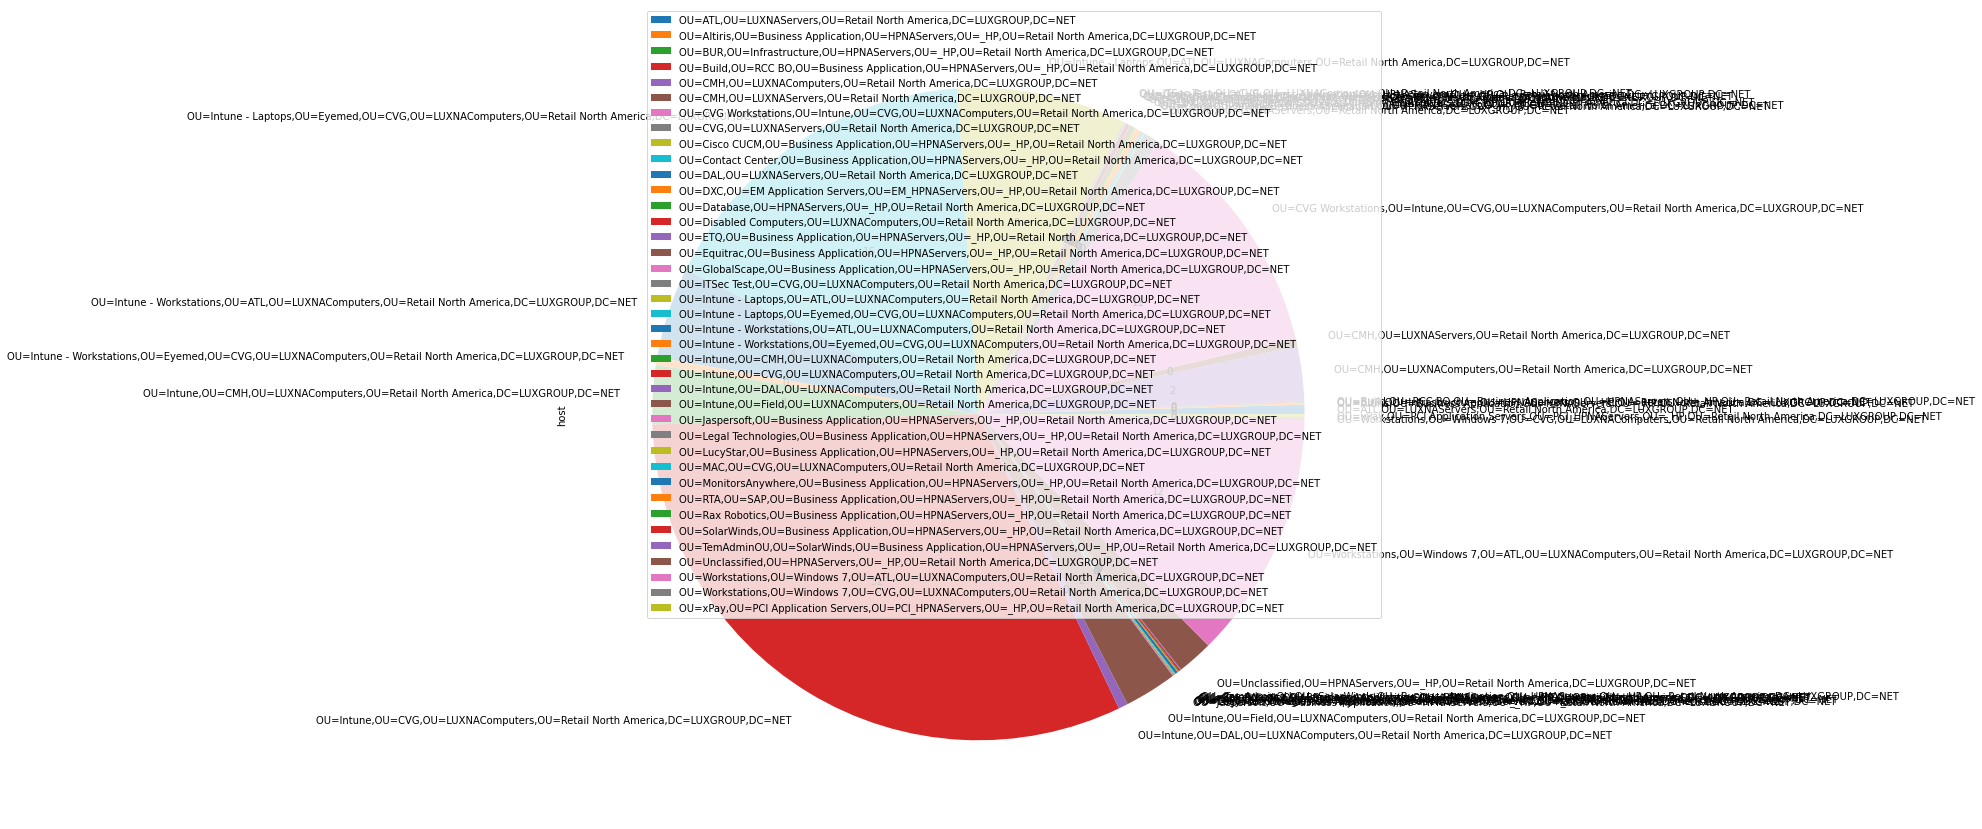

In [10]:
# V1.0 => PLOT THE PIE CHART
plotty = df_host_dn.groupby('dn').count()
plot = plotty.plot.pie(y='host',autopct="%i", figsize=(15,15))
plot
# filter ALB listening on ports 443 and 80 
# pie chart per HTTP return code
#ports = [80, 443]
#dff = df[df.Port.isin(ports)]
#plott = dff.groupby('HTTP return code').count()
#plot = plott.plot.pie(y='Host', autopct="%i", figsize=(5, 5))

In [19]:
# V1.1 => SUNBURST CHART / BUILD THE DF 
int_level_max = 0
int_level_base_dn = 0

if str_base_dn != "":
    dict_base_dn = ldap3.utils.dn.parse_dn(str_base_dn)
    int_level_base_dn = len(dict_base_dn)
else:
    dict_base_dn = None

print ("Base : " + str_base_dn + "\nBase DN : " + str(dict_base_dn) + "\nNb niveaux : " + str(int_level_base_dn))

### STEP 1: Compute the number of OU levels / Initialize the list_OUs
for str_dn in df_host_dn['dn']:
  
    # get the dn + base + level_max
    dict_dn_short=""
    dict_dn_cast = ldap3.utils.dn.parse_dn(str_dn)
    int_dn_len = len(dict_dn_cast)
    if ( int_dn_len > int_level_max):
        int_level_max = int_dn_len

w, h = len(df_dnlist[1]), int_level_max
list_OUs = [[None for x in range(w)] for y in range(h)] 

print("Nb niveaux max: " + str(int_level_max))

### STEP 2: Populate df_OUs
idx=0
for str_dn in df_host_dn['dn']:
           
    dict_dn_cast = ldap3.utils.dn.parse_dn(str_dn)
    int_dn_len = len(dict_dn_cast)

    i = int_dn_len - 1
    for xn in dict_dn_cast: 
        ou = xn[0]+"="+xn[1]
        list_OUs[i][idx] = ou
        i = i - 1

    idx = idx + 1

Base : OU=Retail North America,DC=LUXGROUP,DC=NET
Base DN : [('OU', 'Retail North America', ','), ('DC', 'LUXGROUP', ','), ('DC', 'NET', '')]
Nb niveaux : 3
Nb niveaux max: 5


In [20]:
# V1.1 => PLOT THE SUNBURST CHART 
import plotly.express as px
from plotly.offline import iplot 

hits = [1 for x in range(idx)]
dff = pd.DataFrame(dict(ou0=list_OUs[0], ou1=list_OUs[1], ou2=list_OUs[2], ou3=list_OUs[3], ou4=list_OUs[4], hits=hits))
#dff = dff.dropna()
fig = px.sunburst(dff, path=['ou0','ou1', 'ou2', 'ou3', 'ou4'],values='hits')
fig.show()

In [21]:
# EXPORT THE CHART TO SVG
import plotly.graph_objects as go
f = go.Figure( fig)
f.write_image("fig1.svg")